<a href="https://colab.research.google.com/github/IJ-Jany/datamining3/blob/main/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crawling Phase

In [ ]:
#PROJECT 3(Crawling Phase)

import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import re
from urllib.parse import urljoin, urlparse

# Download stopwords
nltk.download('stopwords')

# Setup stopwords list
STOPWORDS = set(stopwords.words('english'))
additional_stopwords = []  # You can add custom stopwords here
STOPWORDS.update(additional_stopwords)

# Data structures for indexing and link graph
inverted_index = defaultdict(set)
all_urls = set()
link_graph = {'from': [], 'to': []}

def preprocess_text(text):
    # Remove punctuation, lowercase, split, and remove stopwords
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    return [word for word in tokens if word not in STOPWORDS and len(word) > 1]

def crawl_page(url, domain, visited, max_visits, depth_limit):
    if depth_limit == 0 or len(visited) >= max_visits or url in visited:
        return

    try:
        response = requests.get(url, timeout=5)
        if response.status_code != 200:
            return
    except requests.RequestException:
        return

    visited.add(url)
    print(f"Crawled URL ({len(visited)}/{max_visits}): {url}")

    soup = BeautifulSoup(response.content, 'html.parser')
    page_text = soup.get_text(separator=' ', strip=True)
    tokens = preprocess_text(page_text)

    for token in tokens:
        inverted_index[token].add(url)
    all_urls.add(url)

    for link_tag in soup.find_all('a', href=True):
        full_link = urljoin(url, link_tag['href'])
        parsed_link = urlparse(full_link)

        # Save link info for graph
        link_graph['from'].append(url)
        link_graph['to'].append(full_link)

        # Crawl only links within the domain
        if parsed_link.netloc == domain:
            crawl_page(full_link, domain, visited, max_visits, depth_limit - 1)

def start_crawl(seed_urls, max_depth=3, max_visits_per_seed=30):
    for seed_url in seed_urls:
        domain = urlparse(seed_url).netloc
        print(f"\nStarting crawl at seed URL: {seed_url}")
        visited_set = set()
        crawl_page(seed_url, domain, visited_set, max_visits_per_seed, max_depth)

# Define domain-specific seed URLs (world news example)
seed_urls = [
    'https://www.bbc.com/news',
    'https://www.theguardian.com/world',
]

# Begin crawling
start_crawl(seed_urls, max_depth=4, max_visits_per_seed=20)

# Show a sample of the inverted index
print("\nInverted Index Sample (first 15 terms):")
for term in list(inverted_index.keys())[:15]:
    print(f"{term}: {list(inverted_index[term])}")

# Show sample link connections
print("\nSample Link Graph Edges (first 15):")
for src, tgt in list(zip(link_graph['from'], link_graph['to']))[:15]:
    print(f"{src} -> {tgt}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Starting crawl at seed URL: https://www.bbc.com/news
Crawled URL (1/20): https://www.bbc.com/news
Crawled URL (2/20): https://www.bbc.com/news#main-content
Crawled URL (3/20): https://www.bbc.com/
Crawled URL (4/20): https://www.bbc.com/#main-content
Crawled URL (5/20): https://www.bbc.com/sport
Crawled URL (6/20): https://www.bbc.com/business
Crawled URL (7/20): https://www.bbc.com/innovation
Crawled URL (8/20): https://www.bbc.com/culture
Crawled URL (9/20): https://www.bbc.com/arts
Crawled URL (10/20): https://www.bbc.com/travel
Crawled URL (11/20): https://www.bbc.com/future-planet
Crawled URL (12/20): https://www.bbc.com/audio
Crawled URL (13/20): https://www.bbc.com/video
Crawled URL (14/20): https://www.bbc.com/live
Crawled URL (15/20): https://www.bbc.com/home
Crawled URL (16/20): https://www.bbc.com/news/topics/c2vdnvdg6xxt
Crawled URL (17/20): https://www.bbc.com/news/war-in-ukraine
Crawled URL (18/20): https://www.bbc.com/news/us-canada
Crawled URL (19/20): https://www.bbc.

# Searching Phase

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


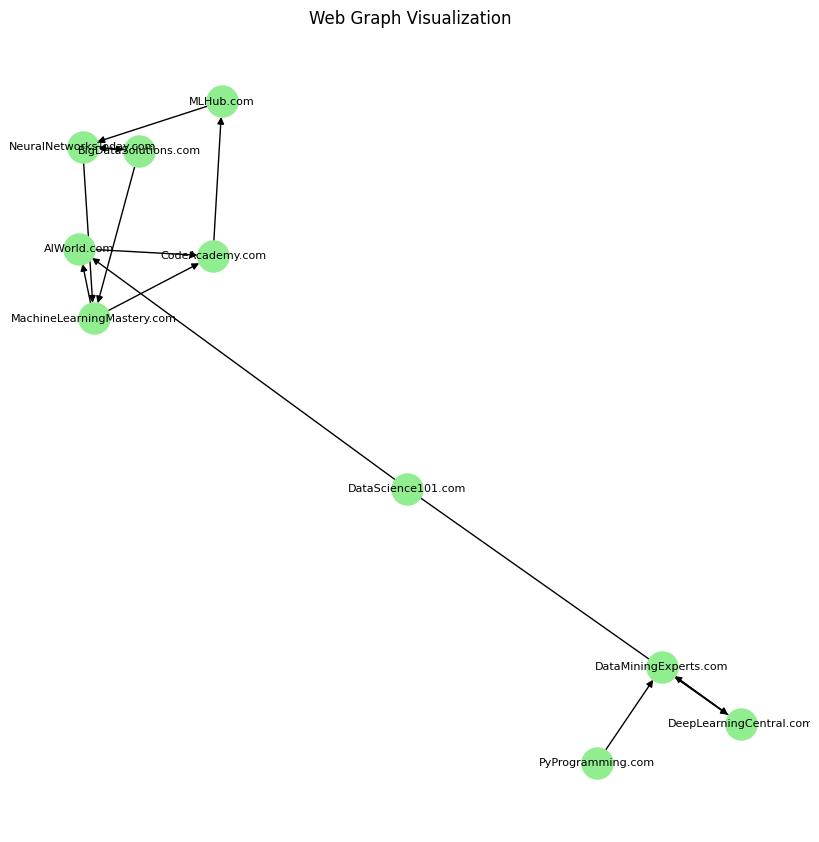

Total nodes: 10
Total edges: 14

Sample Website Content:
CodeAcademy.com:
This is sample content related to CodeAcademy.com...

DataScience101.com:
This is sample content related to DataScience101.com...

MachineLearningMastery.com:
This is sample content related to MachineLearningMastery.com...

PyProgramming.com:
This is sample content related to PyProgramming.com...

DeepLearningCentral.com:
This is sample content related to DeepLearningCentral.com...


HITS Hub Scores:
{'CodeAcademy.com': 4.877651929249043e-17, 'MLHub.com': -3.576944748115965e-16, 'DataScience101.com': 0.3535533905932743, 'DeepLearningCentral.com': -0.0, 'MachineLearningMastery.com': 0.3535533905932743, 'AIWorld.com': 0.14644660940672646, 'PyProgramming.com': -0.0, 'DataMiningExperts.com': 0.14644660940672646, 'NeuralNetworksToday.com': -5.040240326890678e-16, 'BigDataSolutions.com': -7.804243086798469e-16}

HITS Authority Scores:
{'CodeAcademy.com': 0.292893218813453, 'MLHub.com': 9.755303858498087e-17, 'DataScien

In [ ]:
#PROJECT 3(Searching Phase)

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import re

# For Colab users: mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load edges data (web graph)
edges_df = pd.read_csv('/content/drive/MyDrive/Data mining/web_graph.csv')

# Generate dummy content for each unique node (Source URLs)
unique_sites = edges_df['Source'].unique()
content_df = pd.DataFrame({
    'URL': unique_sites,
    'Content': [f"This is sample content related to {url}" for url in unique_sites]
})

# Build directed graph from edges
graph = nx.DiGraph()
for _, row in edges_df.iterrows():
    graph.add_edge(row['Source'], row['Target'])

# Plot the graph
plt.figure(figsize=(8, 8))
nx.draw(graph, with_labels=True, node_size=500, node_color="lightgreen",
        font_size=8, font_color="black", arrowsize=10)
plt.title("Web Graph Visualization")
plt.show()

# Prepare content dictionary: URL -> Content
url_content = dict(zip(content_df['URL'], content_df['Content']))

# Print graph statistics
print(f"Total nodes: {graph.number_of_nodes()}")
print(f"Total edges: {graph.number_of_edges()}")

# Show some sample website content
print("\nSample Website Content:")
for url, content in list(url_content.items())[:5]:
    print(f"{url}:\n{content[:150]}...\n")

# --- Link Analysis ---

# Compute HITS scores
hub_scores, auth_scores = nx.hits(graph, max_iter=100, tol=1e-6)
print("\nHITS Hub Scores:")
print(hub_scores)
print("\nHITS Authority Scores:")
print(auth_scores)

# Compute PageRank scores
pr_scores = nx.pagerank(graph, alpha=0.85, max_iter=100, tol=1e-6)
print("\nPageRank Scores:")
print(pr_scores)

# Function to build a basic inverted index from content
def create_inverted_index(content_map):
    inverted = {}
    for url, text in content_map.items():
        # Tokenize and clean words
        tokens = text.lower().split()
        for word in tokens:
            clean_word = re.sub(r'[^a-zA-Z0-9]', '', word)
            if clean_word:
                inverted.setdefault(clean_word, set()).add(url)
    return inverted

# Build inverted index
inverted_index = create_inverted_index(url_content)

# Display some inverted index entries
print("\nSample Inverted Index Entries:")
for term, urls in list(inverted_index.items())[:10]:
    print(f"{term}: {list(urls)}")

# Simple search engine function based on keyword intersection and ranking
def keyword_search(query, inverted_idx, ranking_scores):
    query_words = [re.sub(r'[^a-zA-Z0-9]', '', w.lower()) for w in query.split()]
    matched_urls = None
    for word in query_words:
        if word in inverted_idx:
            if matched_urls is None:
                matched_urls = inverted_idx[word].copy()
            else:
                matched_urls &= inverted_idx[word]  # intersection for multi-word queries
        else:
            matched_urls = set()
            break
    if not matched_urls:
        return []

    # Rank results by score
    ranked = sorted(
        ((url, ranking_scores.get(url, 0)) for url in matched_urls),
        key=lambda x: x[1], reverse=True
    )
    return ranked

# Search example using PageRank
query = "neural network"
print(f"\nSearch results for '{query}' (PageRank):")
page_rank_results = keyword_search(query, inverted_index, pr_scores)
if page_rank_results:
    for url, score in page_rank_results:
        snippet = url_content.get(url, "")[:150]
        print(f"{url}: {score:.4f}")
        print(f"Snippet: {snippet}...\n")
else:
    print("No results found.")

# Search example using HITS authority scores
print(f"\nSearch results for '{query}' (HITS Authority):")
hits_auth_results = keyword_search(query, inverted_index, auth_scores)
if hits_auth_results:
    for url, score in hits_auth_results:
        snippet = url_content.get(url, "")[:150]
        print(f"{url}: {score:.4f}")
        print(f"Snippet: {snippet}...\n")
else:
    print("No results found.")
